In [1]:
%cat 0Source_Citation.txt

Source and citation

- This notebook is a part of the `pytheos` package.
- Website: http://github.com/SHDShim/pytheos.
- How to cite: S.-H. Shim (2017) Pytheos - a python tool set for equations of state. DOI:


In [2]:
%matplotlib inline 
# %matplotlib notebook # for interactive

For high dpi displays.

In [3]:
%config InlineBackend.figure_format = 'retina'

# 0. General note

- This notebook shows an example of how to conduct equation of state fitting for the pressure-volume-temperature data using `pytheos`.

- Advantage of using `pytheos` is that you can apply different pressure scales and different equations without much coding.  

- We use data on SiC from [Nisr et al. (2017, JGR-Planet)]().

# 1. Global setup

In [4]:
import numpy as np
import uncertainties as uct
from uncertainties import unumpy as unp
import matplotlib.pyplot as plt
import pytheos as eos

# 2. Setups for fitting with two different gold pressure scales

Equations of state of gold from Fei et al. (2007, PNAS) and Dorogokupets and Dewaele (2007, HPR).  These equations are provided from `pytheos` as built-in classes.

In [5]:
au_eos = {'Fei2007': eos.gold.Fei2007bm3(), 'Dorogokupets2007': eos.gold.Dorogokupets2007()}

Because we use Birch-Murnaghan eos version of Fei2007 and Dorogokupets2007 used Vinet eos, we create a dictionary to provide different static compression eos for the different pressure scales used.

In [6]:
st_model = {'Fei2007': eos.BM3Model, 'Dorogokupets2007': eos.VinetModel}

In [7]:
k0_3c = {'Fei2007': 241.2, 'Dorogokupets2007': 243.0}
k0p_3c = {'Fei2007': 2.84, 'Dorogokupets2007': 2.68}
k0_6h = {'Fei2007': 243.1, 'Dorogokupets2007': 245.5}
k0p_6h = {'Fei2007': 2.79, 'Dorogokupets2007': 2.59}

Initial guess:

In [8]:
gamma0 = 1.06
q = 1.
theta0 = 1200.

Physical constants for different materials

In [9]:
v0 = {'3C': 82.8042, '6H': 124.27}
n_3c = 2.; z_3c = 4.
n_6h = 2.; z_6h = 6.

# 3. Setup data (3C)

Data file is in `csv` format.

In [10]:
data = np.recfromcsv('./data/3C-HiTEOS-final.csv', case_sensitive=True, deletechars='')

In [11]:
v_std = unp.uarray( data['V(Au)'], data['sV(Au)'])
temp = unp.uarray(data['T(3C)'], data['sT(3C)'])
v = unp.uarray(data['V(3C)'], data['sV(3C)'])

`pytheos` provides `plot.thermal_data` function to show the data distribution in the P-V and P-T spaces.

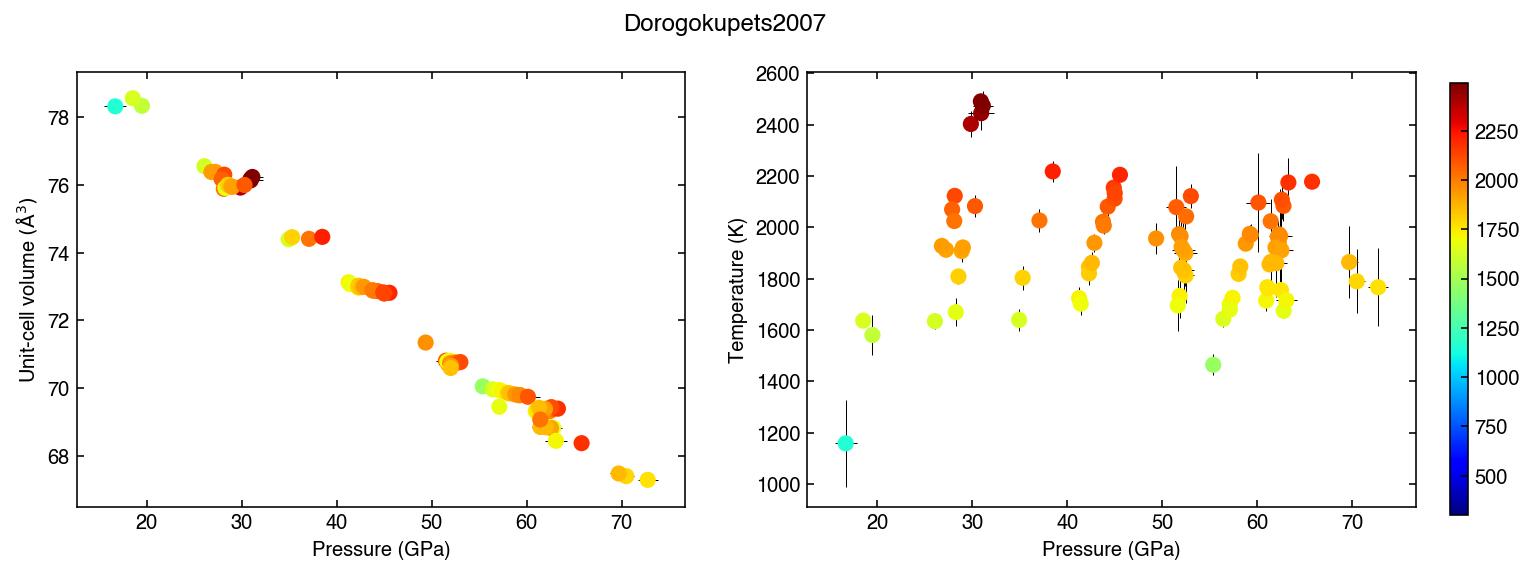

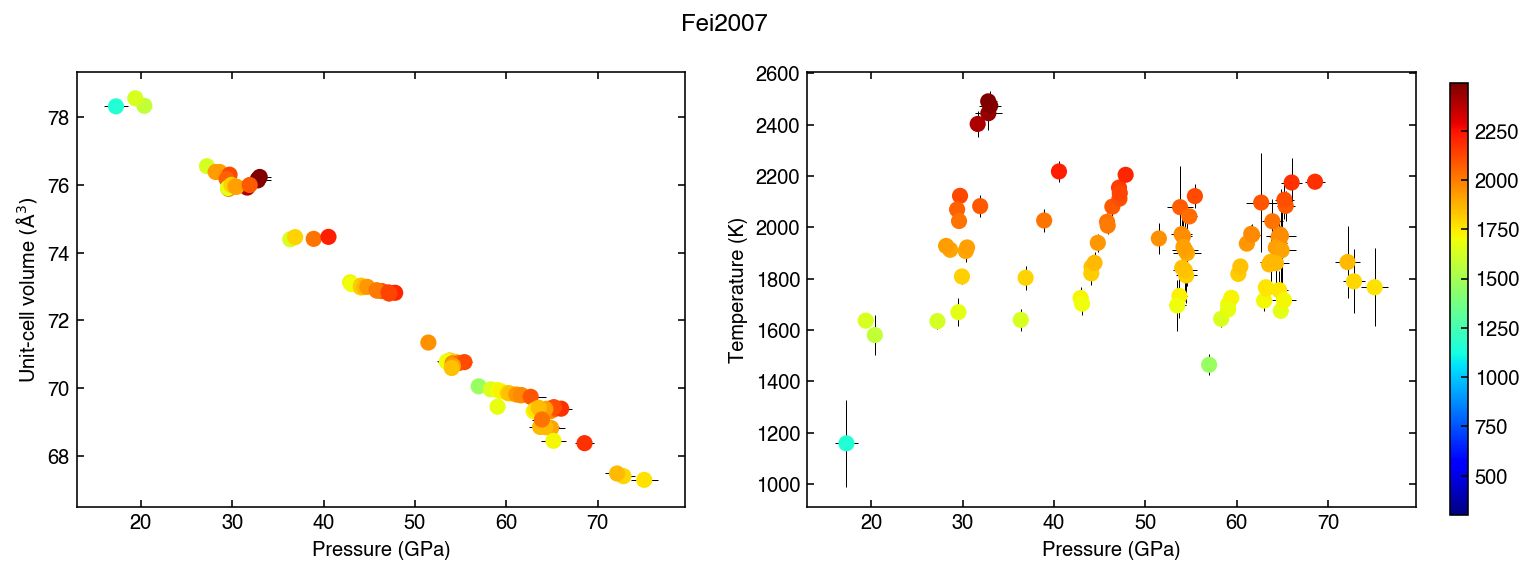

In [12]:
for key, value in au_eos.items(): # iterations for different pressure scales
    p = au_eos[key].cal_p(v_std, temp)
    eos.plot.thermal_data({'p': p, 'v': v, 'temp': temp}, title=key)

# 4. Data fitting with constq equation (3C)

The cell below shows fitting using constant q assumptions for the thermal part of eos.

Normally weight for each data point can be calculated from $\sigma(P)$.  In this case, using `uncertainties`, we can easily propagate the temperature and volume uncertainties to get the value.

/Users/DanShim/anaconda/envs/pytheos-dev/lib/python3.5/site-packages/lmfit/model.py:684: UserWarning: The keyword argument temp does notmatch any arguments of the model function.It will be ignored.
  "It will be ignored.", UserWarning)


********Dorogokupets2007
[[Model]]
    (Model(vinet_p, prefix='st_') + Model(constq_pth, prefix='th_', z='4.0', n='2.0'))
[[Variables]]
    st_v0:       82.8042 (fixed)
    st_k0:       243 (fixed)
    st_k0p:      2.68 (fixed)
    th_v0:       82.8042 (fixed)
    th_gamma0:   1.06 (fixed)
    th_q:        0.77852434 +/- 0.136120 (17.48%) (init= 1)
    th_theta0:   1200 (fixed)



/Users/DanShim/anaconda/envs/pytheos-dev/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


********Fei2007
[[Model]]
    (Model(bm3_p, prefix='st_') + Model(constq_pth, prefix='th_', z='4.0', n='2.0'))
[[Variables]]
    st_v0:       82.8042 (fixed)
    st_k0:       241.2 (fixed)
    st_k0p:      2.84 (fixed)
    th_v0:       82.8042 (fixed)
    th_gamma0:   1.06 (fixed)
    th_q:       -1.29863817 +/- 0.100452 (7.74%) (init= 1)
    th_theta0:   1200 (fixed)



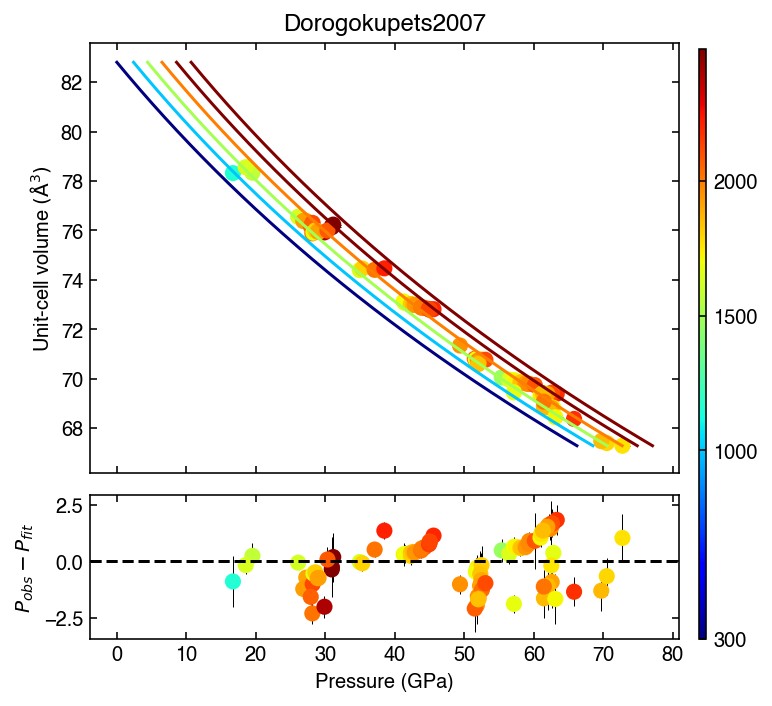

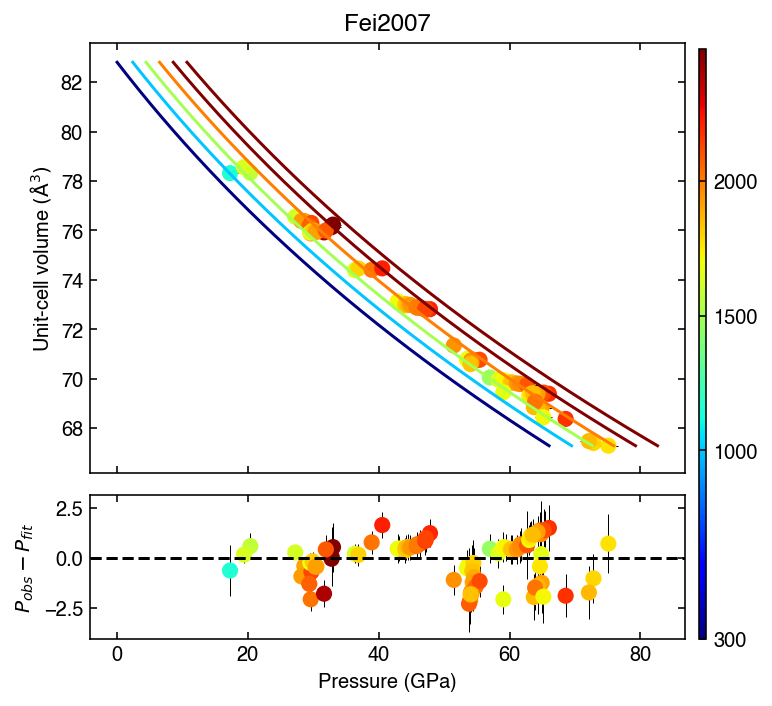

In [13]:
for key, value in au_eos.items(): # iteration for different pressure scales
    # calculate pressure
    p = au_eos[key].cal_p(v_std, temp)
    # add prefix to the parameters.  
    # this is important to distinguish thermal and static parameters
    eos_st = st_model[key](prefix='st_') 
    eos_th = eos.ConstqModel(n_3c, z_3c, prefix='th_')
    # define initial values for parameters
    params = eos_st.make_params(v0=v0['3C'], k0=k0_3c[key], k0p=k0p_3c[key])
    params += eos_th.make_params(v0=v0['3C'], gamma0=gamma0, q=q, theta0=theta0)
    # construct PVT eos
    # here we take advantage of lmfit to combine any formula of static and thermal eos's
    pvteos = eos_st + eos_th
    # fix static parameters and some other well known parameters
    params['th_v0'].vary=False; params['th_gamma0'].vary=False; params['th_theta0'].vary=False
    params['st_v0'].vary=False; params['st_k0'].vary=False; params['st_k0p'].vary=False
    # calculate weights.  setting it None results in unweighted fitting
    weights = 1./unp.std_devs(p) #None
    fit_result = pvteos.fit(unp.nominal_values(p), params, v=unp.nominal_values(v), 
                                   temp=unp.nominal_values(temp), weights=weights)
    print('********'+key)
    print(fit_result.fit_report())
    # plot fitting results
    eos.plot.thermal_fit_result(fit_result, p_err=unp.std_devs(p), v_err=unp.std_devs(v), title=key)

The warning message above is because the static EOS does not need temperature.  `lmfit` generates warning if an assigned independent variable is not used in fitting for any components.

# 5. Data fitting with Dorogokupets2007 equation (3C)

The cell below shows fitting using Altschuler equation for the thermal part of eos.

In [14]:
gamma_inf = 0.4
beta = 1.

/Users/DanShim/anaconda/envs/pytheos-dev/lib/python3.5/site-packages/lmfit/model.py:684: UserWarning: The keyword argument temp does notmatch any arguments of the model function.It will be ignored.
  "It will be ignored.", UserWarning)


********Dorogokupets2007
[[Model]]
    (Model(vinet_p, prefix='st_') + Model(dorogokupets2007_pth, prefix='th_', z='4.0', n='2.0'))
[[Variables]]
    st_v0:          82.8042 (fixed)
    st_k0:          243 (fixed)
    st_k0p:         2.68 (fixed)
    th_v0:          82.8042 (fixed)
    th_gamma0:      1.06 (fixed)
    th_gamma_inf:   0.94009736 +/- 0.021894 (2.33%) (init= 0.4)
    th_beta:        104.737556 +/- 6.71e+03 (6403.45%) (init= 1)
    th_theta0:      1200 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(th_gamma_inf, th_beta)     = -0.542 



/Users/DanShim/anaconda/envs/pytheos-dev/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


********Fei2007
[[Model]]
    (Model(bm3_p, prefix='st_') + Model(dorogokupets2007_pth, prefix='th_', z='4.0', n='2.0'))
[[Variables]]
    st_v0:          82.8042 (fixed)
    st_k0:          241.2 (fixed)
    st_k0p:         2.84 (fixed)
    th_v0:          82.8042 (fixed)
    th_gamma0:      1.06 (fixed)
    th_gamma_inf:   2.48345611 +/- 6.920584 (278.67%) (init= 0.4)
    th_beta:        1.10880946 +/- 5.881810 (530.46%) (init= 1)
    th_theta0:      1200 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(th_gamma_inf, th_beta)     = -1.000 



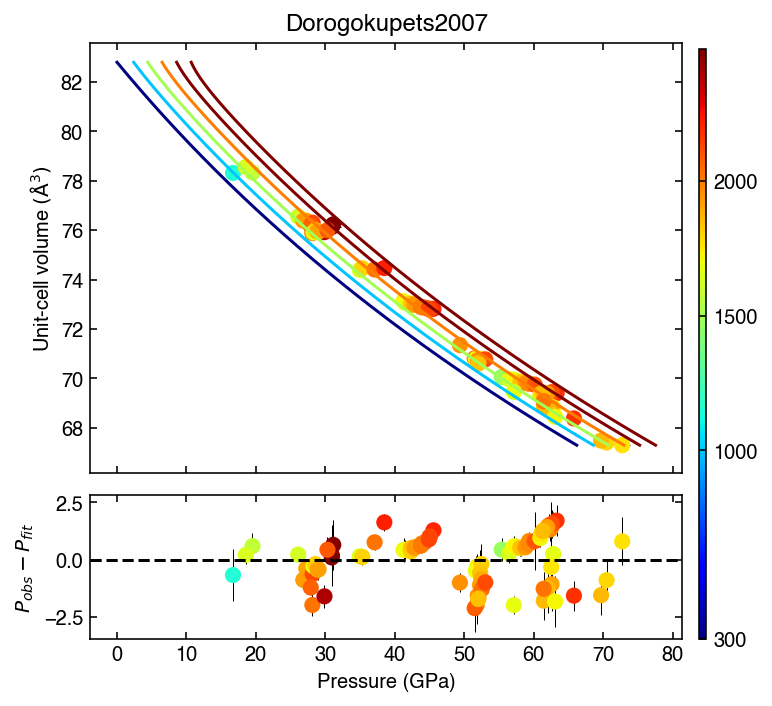

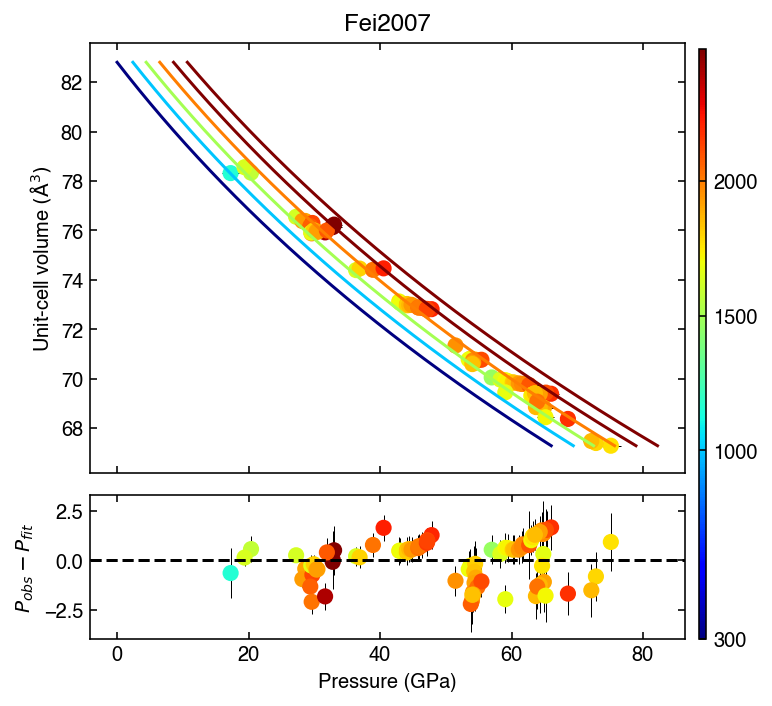

In [15]:
for key, value in au_eos.items():
    # calculate pressure
    p = au_eos[key].cal_p(v_std, temp)
    # add prefix to the parameters.  this is important to distinguish thermal and static parameters
    eos_st = st_model[key](prefix='st_') 
    eos_th = eos.Dorogokupets2007Model(n_3c, z_3c, prefix='th_')
    # define initial values for parameters
    params = eos_st.make_params(v0=v0['3C'], k0=k0_3c[key], k0p=k0p_3c[key])
    params += eos_th.make_params(v0=v0['3C'], gamma0=gamma0, gamma_inf=gamma_inf, beta=beta, theta0=theta0)
    # construct PVT eos
    pvteos = eos_st + eos_th
    # fix static parameters and some other well known parameters
    params['th_v0'].vary=False; params['th_theta0'].vary=False; params['th_gamma0'].vary=False; 
    params['st_v0'].vary=False; params['st_k0'].vary=False; params['st_k0p'].vary=False
    # calculate weights.  setting it None results in unweighted fitting
    weights = None #1./unp.std_devs(p) #None
    fit_result = pvteos.fit(unp.nominal_values(p), params, v=unp.nominal_values(v), 
                                   temp=unp.nominal_values(temp))#, weights=weights)
    print('********'+key)
    print(fit_result.fit_report())
    # plot fitting results
    eos.plot.thermal_fit_result(fit_result, p_err=unp.std_devs(p), v_err=unp.std_devs(v), title=key)

# 6. Data fitting with Speziale equation (3C)

Speziale et al. (2000) presented a different way to describe the behavior of the Gruniense parameter.

In [16]:
q0 = 1.
q1 = 1.

/Users/DanShim/anaconda/envs/pytheos-dev/lib/python3.5/site-packages/lmfit/model.py:684: UserWarning: The keyword argument temp does notmatch any arguments of the model function.It will be ignored.
  "It will be ignored.", UserWarning)


********Dorogokupets2007
[[Model]]
    (Model(vinet_p, prefix='st_') + Model(speziale_pth, prefix='th_', z='4.0', n='2.0'))
[[Variables]]
    st_v0:       82.8042 (fixed)
    st_k0:       243 (fixed)
    st_k0p:      2.68 (fixed)
    th_v0:       82.8042 (fixed)
    th_gamma0:   1.06 (fixed)
    th_q0:       12.8082620 +/- 777.1142 (6067.29%) (init= 1)
    th_q1:       106.689750 +/- 6.46e+03 (6057.75%) (init= 1)
    th_theta0:   1200 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(th_q0, th_q1)              =  1.000 



/Users/DanShim/anaconda/envs/pytheos-dev/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


********Fei2007
[[Model]]
    (Model(bm3_p, prefix='st_') + Model(speziale_pth, prefix='th_', z='4.0', n='2.0'))
[[Variables]]
    st_v0:       82.8042 (fixed)
    st_k0:       241.2 (fixed)
    st_k0p:      2.84 (fixed)
    th_v0:       82.8042 (fixed)
    th_gamma0:   1.06 (fixed)
    th_q0:      -1.48459509 +/- 0.664691 (44.77%) (init= 1)
    th_q1:       2.37859245 +/- 5.810852 (244.30%) (init= 1)
    th_theta0:   1200 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(th_q0, th_q1)              = -0.984 



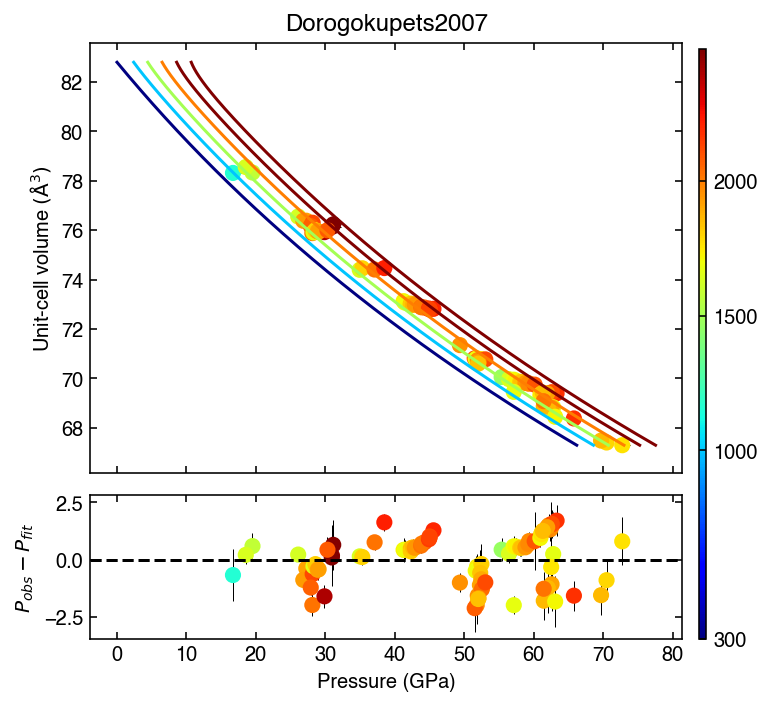

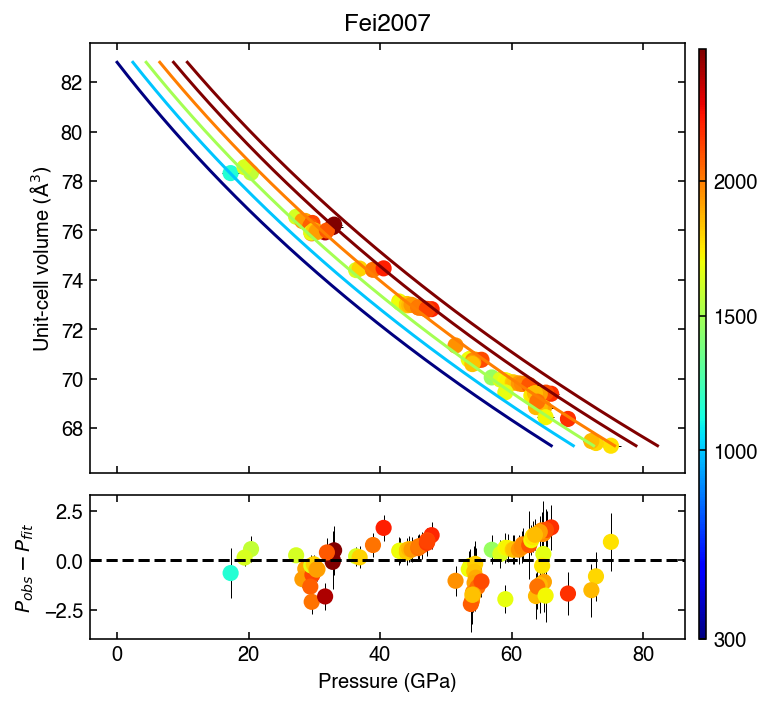

In [17]:
for key, value in au_eos.items():
    # calculate pressure
    p = au_eos[key].cal_p(v_std, temp)
    # add prefix to the parameters.  this is important to distinguish thermal and static parameters
    eos_st = st_model[key](prefix='st_') 
    eos_th = eos.SpezialeModel(n_3c, z_3c, prefix='th_')
    # define initial values for parameters
    params = eos_st.make_params(v0=v0['3C'], k0=k0_3c[key], k0p=k0p_3c[key])
    params += eos_th.make_params(v0=v0['3C'], gamma0=gamma0, q0=q0, q1=q1, theta0=theta0)
    # construct PVT eos
    pvteos = eos_st + eos_th
    # fix static parameters and some other well known parameters
    params['th_v0'].vary=False; params['th_theta0'].vary=False; params['th_gamma0'].vary=False; 
    params['st_v0'].vary=False; params['st_k0'].vary=False; params['st_k0p'].vary=False
    # calculate weights.  setting it None results in unweighted fitting
    weights = None #1./unp.std_devs(p) #None
    fit_result = pvteos.fit(unp.nominal_values(p), params, v=unp.nominal_values(v), 
                                   temp=unp.nominal_values(temp))#, weights=weights)
    print('********'+key)
    print(fit_result.fit_report())
    # plot fitting results
    eos.plot.thermal_fit_result(fit_result, p_err=unp.std_devs(p), v_err=unp.std_devs(v), title=key)